# Dimensionality Reduction of HI Spectra with Variational Autoencoders

# Install packages

In [16]:
# ! pip install astroML

In [17]:
# !pip install torch-lr-finder

In [18]:
! pip install spectral-cube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Connect and authorize google drive

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
best_rs_1.pickle	       MCMC_
best_rs_2.pickle	       MLPClassifier_MLPRegressor.ipynb
best_rs_3.pickle	       MLPRegressor.ipynb
best_rs_chan400_1.pickle       model.png
catalogged_verification.fits   random_weights.h5
CNN			       rhi_zea.fits
data			       spec64k.npz
fcnm_zea.fits		       tigress
figures			       training_data_kok14_galfa.pickle
Find_GNOMES_sightlines.ipynb   transforms
GNOMES_vs_GALFA_spectra.ipynb  Untitled.ipynb
libs			       vae
lightning_logs		       vae_mlp_decoder.png
MCMC


In [20]:
%cd /content/gdrive/My Drive/Colab Notebooks/ML_HI/
!ls

/content/gdrive/My Drive/Colab Notebooks/ML_HI
best_rs_1.pickle	       MCMC_
best_rs_2.pickle	       MLPClassifier_MLPRegressor.ipynb
best_rs_3.pickle	       MLPRegressor.ipynb
best_rs_chan400_1.pickle       model.png
catalogged_verification.fits   random_weights.h5
CNN			       rhi_zea.fits
data			       spec64k.npz
fcnm_zea.fits		       tigress
figures			       training_data_kok14_galfa.pickle
Find_GNOMES_sightlines.ipynb   transforms
GNOMES_vs_GALFA_spectra.ipynb  Untitled.ipynb
libs			       vae
lightning_logs		       vae_mlp_decoder.png
MCMC


In [21]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/ML_HI


# Paths

In [22]:
import sys, os
base_path = os.getcwd()

data_path  = os.path.join(base_path, 'data')
vae_path = os.path.join(base_path, 'vae')
saury_data_path = os.path.join(data_path, 'saury', '')

print(base_path)
print(data_path)

/content/gdrive/My Drive/Colab Notebooks/ML_HI
/content/gdrive/My Drive/Colab Notebooks/ML_HI/data


In [48]:
training_data_file = 'Tb_n01_pw02_vs12_512_thick.fits'
rhi_file = 'R_map_n01_pw02_vs12_Tcut_500K_512px.fits'
fcnm_file = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px.fits'

training_data_fits_file = os.path.join(saury_data_path, training_data_file)
training_fcnm_file = os.path.join(saury_data_path, fcnm_file)
training_rhi_file = os.path.join(saury_data_path, rhi_file)

print(training_data_fits_file)
print(training_fcnm_file)
print(training_rhi_file)

/content/gdrive/My Drive/Colab Notebooks/ML_HI/data/saury/Tb_n01_pw02_vs12_512_thick.fits
/content/gdrive/My Drive/Colab Notebooks/ML_HI/data/saury/fcnm_map_n01_pw02_vs12_Tcut_500K_512px.fits
/content/gdrive/My Drive/Colab Notebooks/ML_HI/data/saury/R_map_n01_pw02_vs12_Tcut_500K_512px.fits


# Libraries

In [24]:
sys.path.insert(1, data_path)

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob
import pickle

In [25]:
from astropy.wcs import WCS
from spectral_cube import SpectralCube

# Read training dataset

Training set includes 38781 spectra (1-D spectral data: signal strength T_b as a function of wavelength channels) and their ground-truth cold atomic hydrogen gas fraction (FCNM) and opacity correction factor (R). The training dataset was obtained from a simulation.

FCNM range: from ~0. to (less than) 1.
R range: >= 1

Test dataset consists of 58 spectra from observations.

**Note:** Atomic Hydrogen Gas = HI

In [28]:
hdu = fits.open(training_data_fits_file)
data = hdu[0].data

print(data.shape)

(101, 512, 512)


# Total intensity map (or optically-thin HI column density map)

In [38]:
WHI = np.sum(data, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI # In unit of 10^20 cm-2

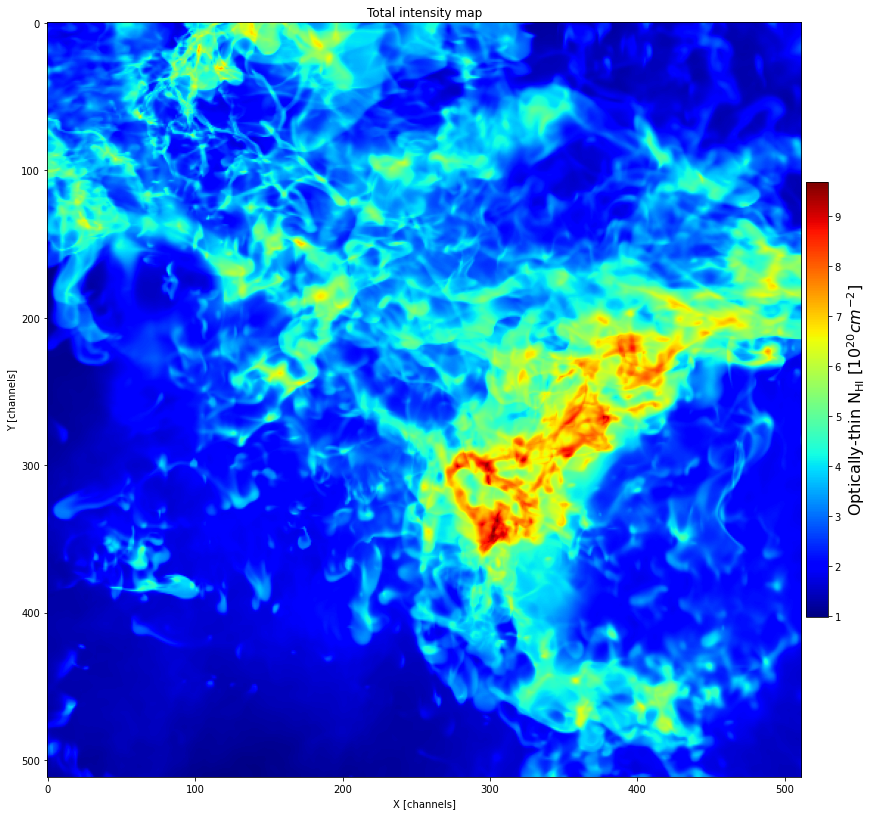

In [47]:
plt.figure(figsize=(16,16))
plt.imshow(NHI_thin, cmap='jet')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20} cm^{-2}$]', size=16)

plt.title('Total intensity map')
plt.xlabel('X [channels]')
plt.ylabel('Y [channels]')
plt.show()

# Ground-truth cold HI gas fraction

In [49]:
hdu = fits.open(training_fcnm_file)
fcnm_data = hdu[0].data

print(fcnm_data.shape)

(512, 512)


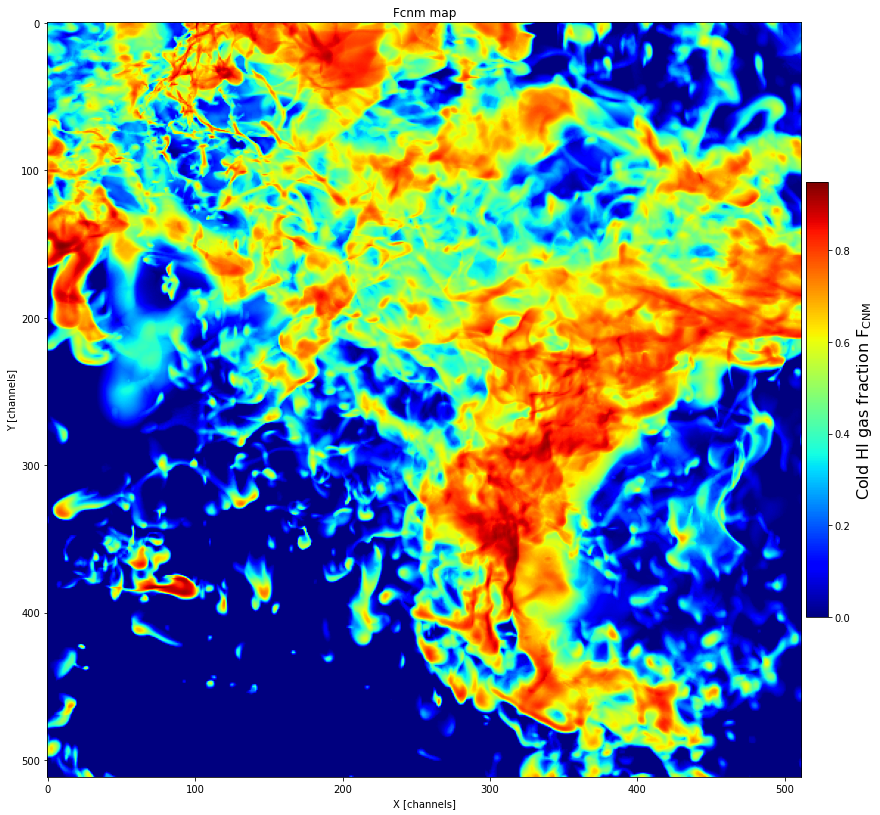

In [50]:
plt.figure(figsize=(16,16))
plt.imshow(fcnm_data, cmap='jet')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Cold HI gas fraction F$_\mathrm{CNM}$', size=16)

plt.title('Fcnm map')
plt.xlabel('X [channels]')
plt.ylabel('Y [channels]')
plt.show()

# Ground-truth opacity correction factor

In [52]:
hdu = fits.open(training_rhi_file)
rhi_data = hdu[0].data

print(rhi_data.shape)

(512, 512)


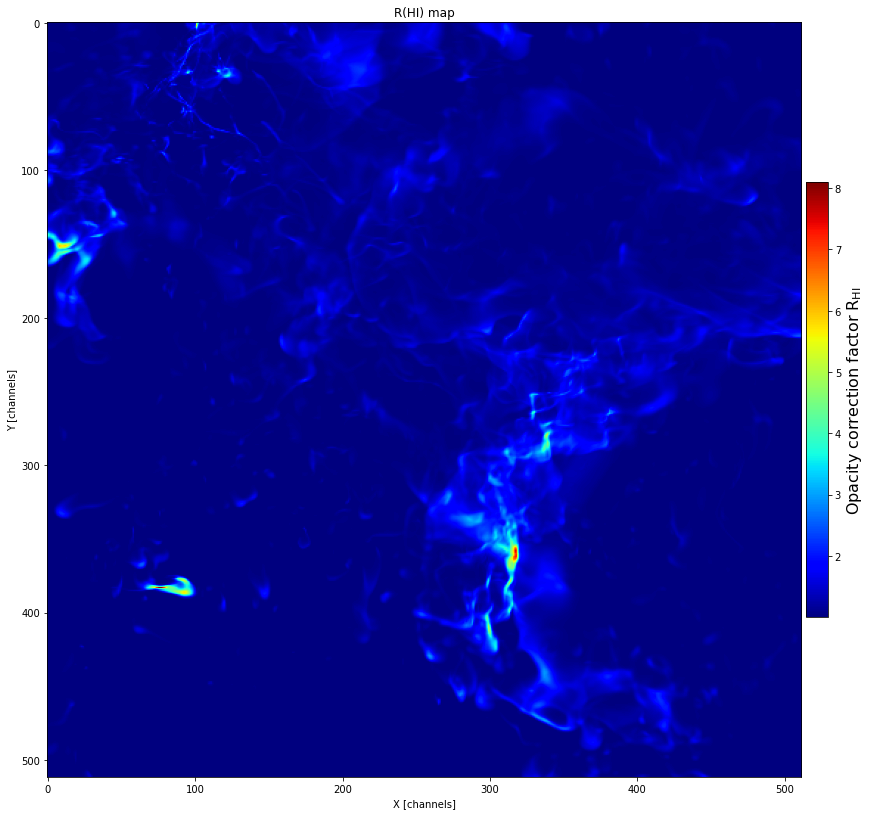

In [53]:
plt.figure(figsize=(16,16))
plt.imshow(rhi_data, cmap='jet')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Opacity correction factor R$_\mathrm{HI}$', size=16)

plt.title('R(HI) map')
plt.xlabel('X [channels]')
plt.ylabel('Y [channels]')
plt.show()

# Plot a few spectra

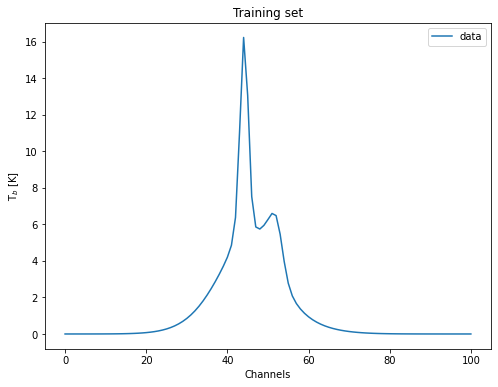

In [29]:
# Spectrum in training set
plt.figure(figsize=(8,6))
plt.plot(data[:, 100, 100], label='data')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

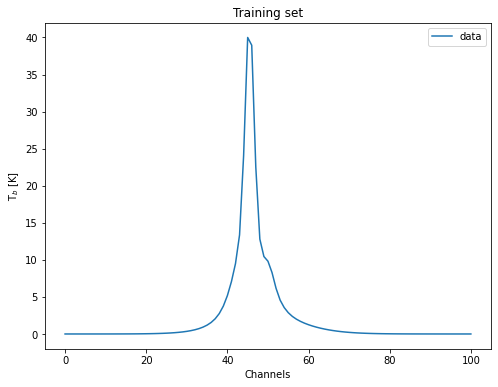

In [30]:
# Spectrum in training set
plt.figure(figsize=(8,6))
plt.plot(data[:, 20, 100], label='data')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

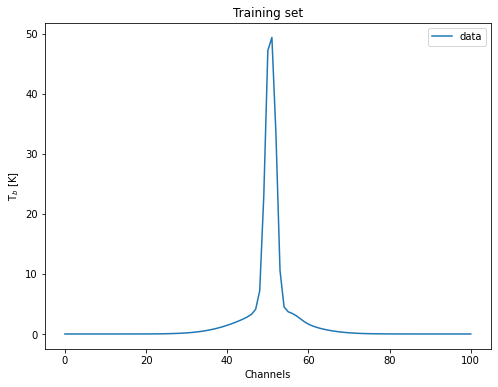

In [31]:
# Spectrum in training set
plt.figure(figsize=(8,6))
plt.plot(data[:, 20, 200], label='data')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

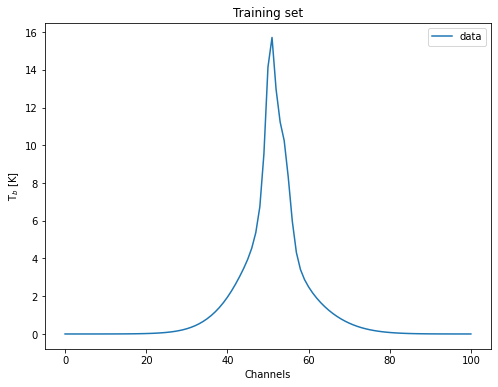

In [32]:
# Spectrum in training set
plt.figure(figsize=(8,6))
plt.plot(data[:, 200, 200], label='data')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

# Images along the wavelength channels

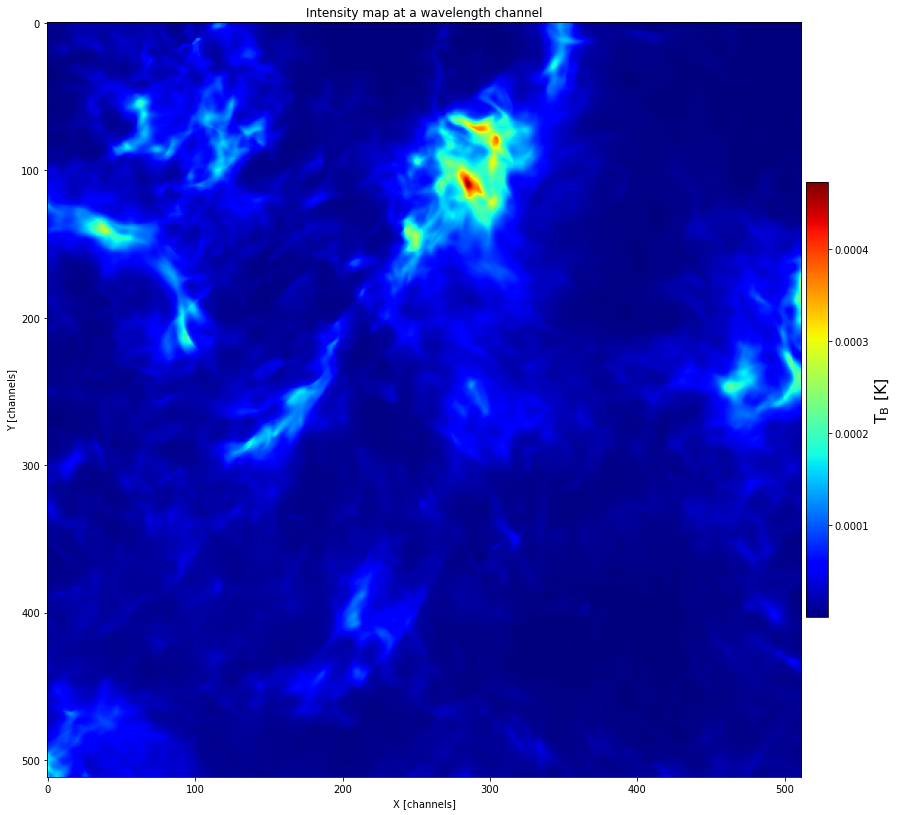

In [54]:
plt.figure(figsize=(16,16))
plt.imshow(data[0, :, :], cmap='jet')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('T$_\mathrm{B}$ [K]', size=16)

plt.title('Intensity map at a wavelength channel')
plt.xlabel('X [channels]')
plt.ylabel('Y [channels]')
plt.show()

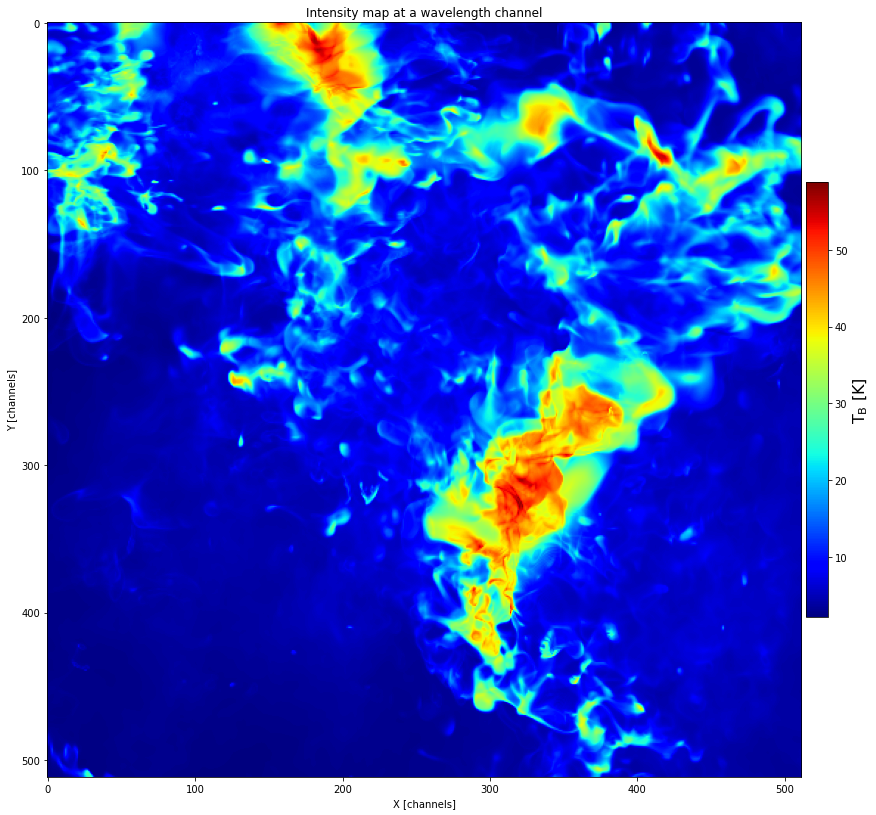

In [56]:
plt.figure(figsize=(16,16))
plt.imshow(data[50, :, :], cmap='jet')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('T$_\mathrm{B}$ [K]', size=16)

plt.title('Intensity map at a wavelength channel')
plt.xlabel('X [channels]')
plt.ylabel('Y [channels]')
plt.show()

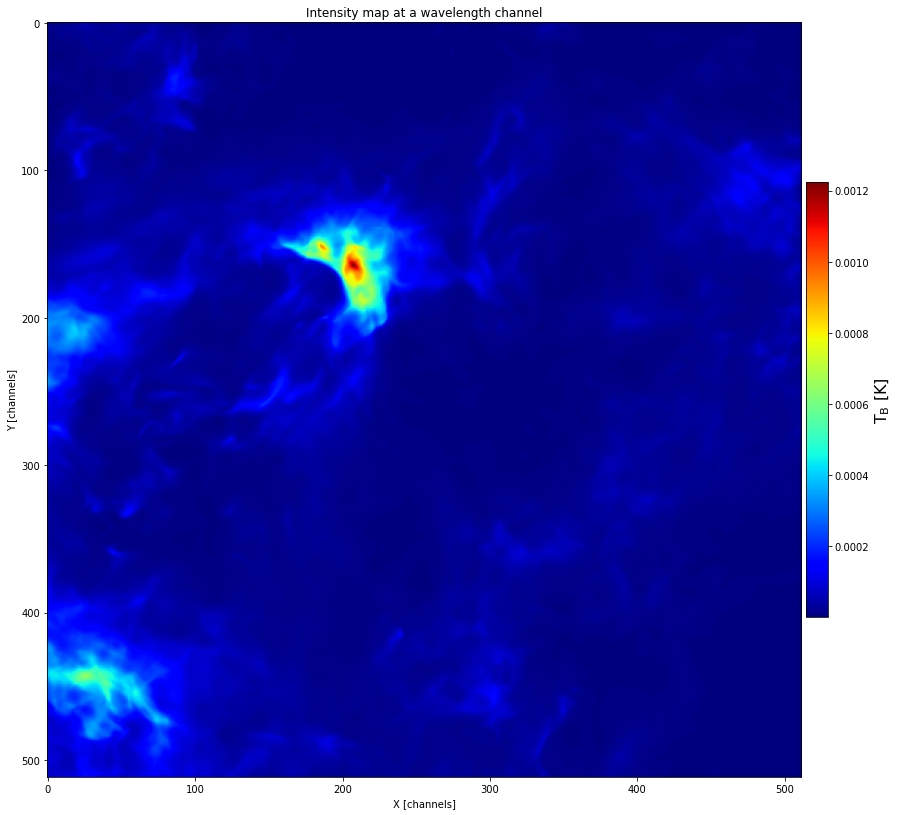

In [55]:
plt.figure(figsize=(16,16))
plt.imshow(data[100, :, :], cmap='jet')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('T$_\mathrm{B}$ [K]', size=16)

plt.title('Intensity map at a wavelength channel')
plt.xlabel('X [channels]')
plt.ylabel('Y [channels]')
plt.show()

# Histogram of FCNM and R

**Note:** Atomic Hydrogen Gas = HI

In [57]:
FCNM = fcnm_data.ravel()
R    = rhi_data.ravel()

In [59]:
FCNM.shape

(262144,)

In [60]:
# stats_series = pd.DataFrame(FCNM).describe()
# series_index = stats_series.index.to_list()
# series_values = stats_series.values.flatten()
# print('FCNM:')
# stats_series

In [61]:
# stats_series = pd.DataFrame(R).describe()
# series_index = stats_series.index.to_list()
# series_values = stats_series.values.flatten()
# print('R:')
# stats_series

## Cold HI gas fraction: FCNM

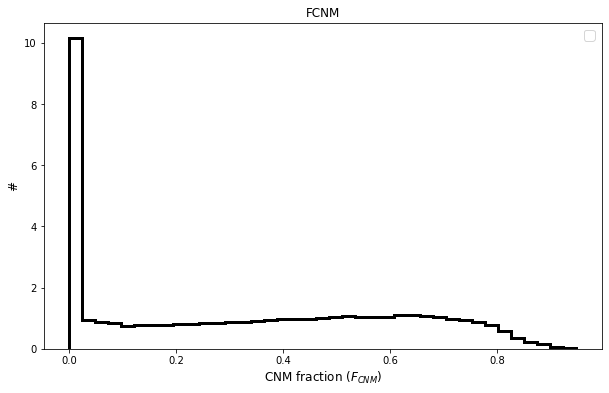

In [65]:
# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(FCNM, bins=np.linspace(0., FCNM.max(), 40),
         density=True, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='')

plt.title(f'FCNM')
plt.xlabel(r'CNM fraction ($F_{CNM}$)', fontsize=12)
plt.ylabel(r'#', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()

## HI Opacity correction  Factor : R

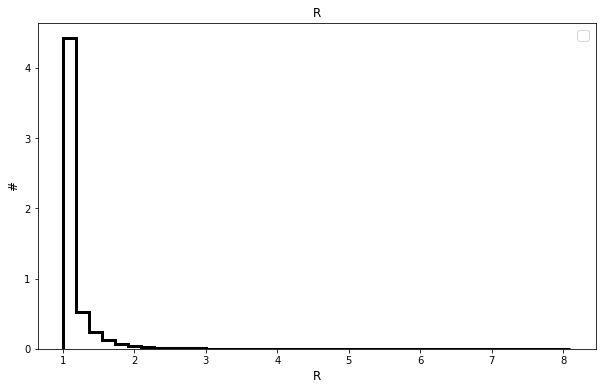

In [64]:
# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(R, bins=np.linspace(1., R.max(), 40),
         density=True, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='')

plt.title(f'R')
plt.xlabel(r'R', fontsize=12)
plt.ylabel(r'#', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()